# ***NUTRIWISE.io***
#### *Trouve les meilleurs ingrédients pour le plat que tu veux manger !*
***
## Problématique
Après une réflexion intense, j'ai enfin choisi ! Ce soir, ce sera spaghetti à la bolognaise.\
Arrivé devant le rayon : difficile ! Un éventail large de pâtes et sauces...\
Mais quels ingrédients sont les meilleurs pour ma santé ? L'environnement ?\
Je n'ai pas envie de scanner chaque code-barre, il me faut quelque chose qui me dise instantanément quoi prendre !\
La solution : **NUTRIWISE.io**

## Données
### Source
Nous utiliserons ici le jeu de données `en.openfoodfacts.org.products.csv` fourni par OpenFoodFacts.

### Variables utilisées

Après exploration des données ***NUTRIWISE.io*** va utiliser les données suivantes :`['code',  'product_name', 'categories_tags', 'pnns_groups_2','countries_tags', 'manufacturing_places_tags', 'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade', 'fiber_100g', 'proteins_100g','energy-kcal_100g','carbon-footprint_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']`

Le but va être de créer un score mêlant le nutriscore et l'ecoscore pour trouver l'ingrédient optimal.
Lorsque le nutriscore est indisponible, nous allons essayer de le déterminer grâce aux teneurs en sucre, gras, gras saturé et sel.
Lorsque l'ecoscore est indisponible, nous allons essayer de le déterminer grâce à l'empreinte carbone.


## Lecture des données

In [1]:
# Imports
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Reading of the CSV file and creation of the DataFrame
# nrows=1 # This value for the tests to improve the running time
cols = ['code',  'product_name', 'categories_tags', 'pnns_groups_2','countries_tags', 'manufacturing_places_tags', \
        'nutriscore_score', 'nutriscore_grade', 'ecoscore_score','ecoscore_grade', \
        'fiber_100g', 'proteins_100g','energy-kcal_100g','carbon-footprint_100g', 'sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']

start_time = time.time()
# # This line to run the reading on a nrows sample
# df= pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', low_memory=True, nrows=nrows)
# for col in df.columns:
#     print(col)

#This line to run the reading on the entire CSV file
df= pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)

end_time = time.time()
print(f"Running time to read csv : {end_time - start_time:.2f} seconds")

total_df_length = len(df)
formatted_total_df_length = format(total_df_length, ',').replace(',', ' ')

/tmp/ipykernel_10829/3227930724.py:14: DtypeWarning: Columns (0,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv('en.openfoodfacts.org.products.csv', sep='\t', usecols=cols, low_memory=True)


Running time to read csv : 39.85 seconds


## Nettoyage des données
### Démarche
#### Contrainte géographique

Dans un premier temps, nous allons nous concentrer sur la France. Notre première étape sera donc de garder les ingrédients seulement vendus en France.
Ensuite, nous enlèverons les doublons de cette base.

6 lignes étaient des doublons parfaits.
Au total, il y avait 2 841 812 lignes dans la base initiale. 
Après avoir gardé seulement les produits vendus en France, il y a 973 810, soit 34.27 % de la base initiale.


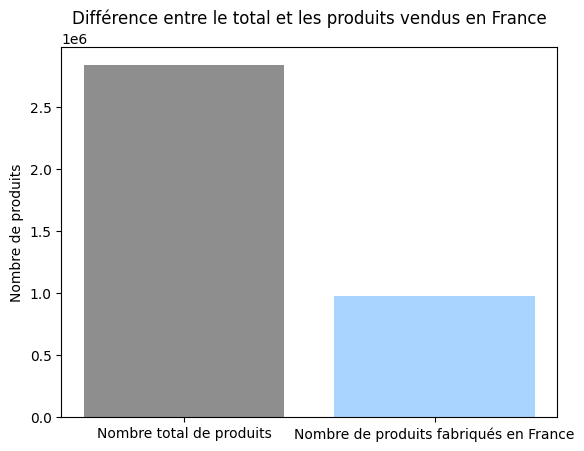

In [3]:
# Drop rows with the selling countries are not known
df = df.dropna(subset=['countries_tags'])


# Filter the rows with only countries_tags that contains 'france'
france_df = df[df['countries_tags'].str.contains('france')]
france_df = france_df[cols]
france_df_length = len(france_df)
formatted_france_df_length = format(france_df_length, ',').replace(',', ' ')
france_df = france_df.drop_duplicates()
france_df_uniques_length = len(france_df)
france_df_backup = france_df
print(f"{france_df_length - france_df_uniques_length} lignes étaient des doublons parfaits.")
print(f"Au total, il y avait {formatted_total_df_length} lignes dans la base initiale. \nAprès avoir gardé seulement les produits vendus en France, il y a {formatted_france_df_length}, soit {round(france_df_length/total_df_length* 100,2)} % de la base initiale.")

# GRAPH
values = [total_df_length, france_df_length]
labels = ["Nombre total de produits", "Nombre de produits fabriqués en France"]
fig, ax = plt.subplots()
ax.bar(labels, values, color=['#8E8E8E', '#A9D4FF'])
ax.set_ylabel('Nombre de produits')
ax.set_title('Différence entre le total et les produits vendus en France')

plt.show()

#### Erreurs lexicales

In [4]:
# check if there are two different data types in each column
for col in france_df.columns:
    if france_df[col].nunique() > 1:
        print(f"{col} : {france_df[col].dtypes}")
        
print("\nOn peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.")

code : object
product_name : object
categories_tags : object
pnns_groups_2 : object
countries_tags : object
manufacturing_places_tags : object
nutriscore_score : float64
nutriscore_grade : object
ecoscore_score : float64
ecoscore_grade : object
fiber_100g : float64
proteins_100g : float64
energy-kcal_100g : float64
carbon-footprint_100g : float64
sugars_100g : float64
fat_100g : float64
saturated-fat_100g : float64
sodium_100g : float64

On peut voir qu'il n'y a rien de particulier ici. Ceux qui doivent être des nombres sont des nombres, ceux qui doivent être du texte sont du texte.


#### Gestion des valeurs nulles
##### Basiques

In [5]:
filled_pct = france_df.count() / len(france_df) * 100
print(filled_pct)

# Remove the lines which do not have product_name
france_df = france_df.dropna(subset=['product_name'])
france_df = france_df.drop(columns=['categories_tags', 'carbon-footprint_100g'])
print(f"La longueur du dataframe est maintenant de {len(france_df)}")

code                         100.000000
product_name                  97.260024
categories_tags               49.264226
pnns_groups_2                 99.945369
countries_tags               100.000000
manufacturing_places_tags      8.754534
nutriscore_score              37.406501
nutriscore_grade              37.406501
ecoscore_score                35.363893
ecoscore_grade                99.900596
fiber_100g                    23.241433
proteins_100g                 76.592518
energy-kcal_100g              74.697167
carbon-footprint_100g          0.032861
sugars_100g                   76.850475
fat_100g                      76.403465
saturated-fat_100g            76.890421
sodium_100g                   72.491590
dtype: float64
La longueur du dataframe est maintenant de 947122


On peut voir qu'il y a des produits qui n'ont pas de nom. Nous n'avons pas vraiment d'autre choix que de les supprimer. \
Les différentes colonnes de catégories ont exactement le même taux de remplissage. Nous choisissons donc de garder les catégories en Français. \
La colonne de carbon-footprint_100g a un très faible taux de remplissage. Pour le moment, nous choisissons de la retirer.
**Les lignes de code correspondants sont dans la cellule au-dessus à la suite du calcul de remplissage.**

#### Variables qualitatives

Dans notre cas, nous allons avoir essentiellement besoin du **Nutriscore** et de l'**Eco-score**. \
Si ces deux valeurs ne sont pas présentes, nous allons essayer de les déduire grâce aux informations nutritionnelles et écologiques présentes pour le produit.
Nous allons donc éliminer les valeurs où tous les champs : `['additives_n','energy-kcal_100g','fiber_100g','proteins_100g','sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g']` sont nuls. \
Si une valeur est présente, nous gardons la ligne pour le moment pour essayer de la déduire. 

En lançant une fois la fonction dropna, nous vyons que l'ecoscore grade est à unknown est pas forcément à nul.
Je vais donc voir quelles sont les valeurs des ecoscore_grade et nutriscore_grade

In [10]:
def remove_quant_var_null_values():
    without_all_characteristics_nan_df = france_df.dropna(subset=['energy-kcal_100g','fiber_100g','proteins_100g','sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g'], thresh=1)
    without_all_characteristics_nan_df_length = len(without_all_characteristics_nan_df)
    formatted_without_all_characteristics_nan_df_length = format(without_all_characteristics_nan_df_length, ',').replace(',', ' ')
    print(f"Il y avait {formatted_france_df_length} produits, après ce nettoyage il y en a : {formatted_without_all_characteristics_nan_df_length}.")
    return without_all_characteristics_nan_df

In [11]:
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df[col].unique()}")

nutriscore_grade : [nan 'a' 'd' 'b' 'c' 'e']
ecoscore_grade : [nan 'd' 'c' 'b' 'e' 'a']


Pour le nutriscore, pas de problème.\
Pour l'eco-score, nous avons deux valeurs qui ne sont pas utilisables : unknown et and not-applicable. Nous les remplacerons par nan. \
Nous relançons ensuite la même fonction que précédement.

In [12]:
france_df['ecoscore_grade'] = france_df['ecoscore_grade'].replace(['unknown', 'not-applicable'], np.nan)
france_df_without_all_null_quant_var = remove_quant_var_null_values()
france_df_without_all_null_quant_var_length = format(len(france_df_without_all_null_quant_var), ',').replace(',', ' ')
cols = ['nutriscore_grade', 'ecoscore_grade']
for col in cols:
    print(f"{col} : {france_df_without_all_null_quant_var[col].unique()}")


Il y avait 973 810 produits, après ce nettoyage il y en a : 762 766.
nutriscore_grade : ['a' nan 'd' 'b' 'c' 'e']
ecoscore_grade : ['d' nan 'c' 'b' 'e' 'a']


Ces deux colonnes sont maintenant uniformes.
#### Variables quantitatives
Attaquons nous maintenant aux variables quantitatives. Il s'agit des colonnes `['fiber_100g','energy-kcal_100g','sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']`. \
Toutes ces variables sont sensées être des proportions sur 100g. Elles ne doivent donc être ni négatives, ni supérieures à 100. Voyons voir la répartition.

In [13]:
# define the bins
bins = [-float('inf'), -1e-15, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')]
cols = ['fiber_100g','energy-kcal_100g','sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']
for col in cols:
    cut_series = pd.cut(france_df_without_all_null_quant_var[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")

Value counts for column 'fiber_100g':
fiber_100g
(-inf, -1e-15]         0
(-1e-15, 10.0]    212617
(10.0, 20.0]        8681
(20.0, 30.0]        1790
(30.0, 40.0]         885
(40.0, 50.0]         353
(50.0, 60.0]         171
(60.0, 70.0]         125
(70.0, 80.0]         105
(80.0, 90.0]         137
(90.0, 100.0]         18
(100.0, inf]           5
Name: count, dtype: int64

Value counts for column 'energy-kcal_100g':
energy-kcal_100g
(-inf, -1e-15]         0
(-1e-15, 10.0]     35080
(10.0, 20.0]       11482
(20.0, 30.0]       14687
(30.0, 40.0]       16026
(40.0, 50.0]       23193
(50.0, 60.0]       14472
(60.0, 70.0]       13296
(70.0, 80.0]       11327
(80.0, 90.0]       11003
(90.0, 100.0]      13676
(100.0, inf]      560330
Name: count, dtype: int64

Value counts for column 'sugars_100g':
sugars_100g
(-inf, -1e-15]         1
(-1e-15, 10.0]    491702
(10.0, 20.0]       73070
(20.0, 30.0]       52496
(30.0, 40.0]       36033
(40.0, 50.0]       29436
(50.0, 60.0]       31478
(60.0, 70.

##### Suppression des valeurs négatives et supérieures à 100
En voyant ça, nous avons deux tris à faire : \
Supprimer toutes les valeurs < 0 pour toutes les colonnes.\
Supprimer les valeurs > 100 pour toutes les colonnes sauf `energy-kcal_100g`

In [14]:
# Remove lines with quantitative values inferior to 0
cols = ['fiber_100g','sugars_100g', 'fat_100g', 'energy-kcal_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']
filtered_france_df = france_df_without_all_null_quant_var
for col in cols:
    filtered_france_df = filtered_france_df.loc[(filtered_france_df[col].isnull()) | (filtered_france_df[col] >= 0)]

print(f"Après suppression des valeurs inférieures à 0, il reste : {len(filtered_france_df)} lignes.")

# Remove lines with quantitatives values superior to 100 except for energy-kcal_100g
cols = ['fiber_100g','sugars_100g', 'fat_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']
for col in cols:
    filtered_france_df = filtered_france_df.loc[(filtered_france_df[col].isnull()) | (filtered_france_df[col] <= 100)]
print(f"Après suppression des valeurs supérieures à 100 il reste : {len(filtered_france_df)} lignes.")
    
france_df_filtered_length = format(len(filtered_france_df), ',').replace(',', ' ')
print(f"Il y avait {france_df_without_all_null_quant_var_length} produits dans la liste, il y en a maintenant {france_df_filtered_length}. \n")

Après suppression des valeurs inférieures à 0, il reste : 762760 lignes.
Après suppression des valeurs supérieures à 100 il reste : 762675 lignes.
Il y avait 762 766 produits dans la liste, il y en a maintenant 762 675. 



Regardons maintenant la colonne `energy-kcal_100g` d'un peu plus près car ses mesures peuvent aller au-delà de 100.

In [15]:
# define the bins
# We already removed the values <0
bins = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 3000, 5000, float('inf')]
cols = ['energy-kcal_100g']
for col in cols:
    cut_series = pd.cut(filtered_france_df[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")


Value counts for column 'energy-kcal_100g':
energy-kcal_100g
(0.0, 200.0]        272062
(200.0, 400.0]      254590
(400.0, 600.0]      150674
(600.0, 800.0]       17887
(800.0, 1000.0]      10598
(1000.0, 1200.0]       390
(1200.0, 1400.0]       347
(1400.0, 1600.0]       327
(1600.0, 1800.0]        34
(1800.0, 2000.0]        19
(2000.0, 3000.0]        28
(3000.0, 5000.0]        16
(5000.0, inf]            6
Name: count, dtype: int64



Nous voyons que nous avons quelques valeurs incohérentes avec des quantités à plus de 1000 kcal pour 100g.\
Après quelques recherches, les huiles qui sont les aliments les plus caloriques pour 100g ont environ 900 kcal pour 100g.\
Nous choisissons donc de remplacer les valeurs qui ont plus de 1000 kcal par 100 grammes par la moyenne de leur catégorie.

In [16]:
# Calculation of groups means
group_means = filtered_france_df.groupby("pnns_groups_2")["energy-kcal_100g"].mean()
print(group_means)

# replace values greater than 1000 with the group mean of corresponding "pnns_groups_2"
filtered_france_df.loc[filtered_france_df["energy-kcal_100g"] > 1000, "energy-kcal_100g"] = filtered_france_df.loc[filtered_france_df["energy-kcal_100g"] > 1000, "pnns_groups_2"].map(group_means)

# print value counts after replacing values
bins = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 3000, 5000, float('inf')]
cols = ['energy-kcal_100g']
for col in cols:
    cut_series = pd.cut(filtered_france_df[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")

print(f"Il y a maintenant {len(filtered_france_df)} produits dans le jeune de données.")

pnns_groups_2
Alcoholic beverages                    73.001168
Appetizers                            433.944631
Artificially sweetened beverages       32.098692
Biscuits and cakes                    427.930399
Bread                                 323.558151
Breakfast cereals                     398.398525
Cereals                               345.501497
Cheese                                338.316510
Chocolate products                    550.577604
Dairy desserts                        131.977696
Dressings and sauces                  236.468072
Dried fruits                          346.499030
Eggs                                  143.644095
Fats                                  805.959167
Fish and seafood                      184.039897
Fruit juices                           46.085407
Fruit nectars                          49.571940
Fruits                                124.485837
Ice cream                             205.983542
Legumes                               301.681507
Meat  

Nous remarquons qu'il y a encore 866 valeurs aberrantes, qui ont sûrement récupéré la valeur moyenne de la catégorie **unknown** qui est de 85304kcal.\
En les affichant, nous voyons qu'il s'agit de valeurs ayant le `pnns_groups_2` à *unknown*.
Nous les retirons donc car non identifiables.

In [17]:
print(f"La ou les catégories qui ont des valeurs de kcal par 100g supérieures à 5000 : {filtered_france_df[filtered_france_df['energy-kcal_100g'] > 5000]['pnns_groups_2'].unique()}") 
filtered_france_df = filtered_france_df[filtered_france_df["energy-kcal_100g"] < 5000]

# Print 
bins = [0, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 3000, 5000, float('inf')]
cols = ['energy-kcal_100g']
for col in cols:
    cut_series = pd.cut(filtered_france_df[col], bins)
    value_counts = cut_series.value_counts(sort=False)
    print(f"Value counts for column '{col}':\n{value_counts}\n")
    
print(f"Il y a maintenant {len(filtered_france_df)} produits dans le jeu de données.")

La ou les catégories qui ont des valeurs de kcal par 100g supérieures à 5000 : ['unknown']
Value counts for column 'energy-kcal_100g':
energy-kcal_100g
(0.0, 200.0]        272122
(200.0, 400.0]      254797
(400.0, 600.0]      150703
(600.0, 800.0]       17887
(800.0, 1000.0]      10603
(1000.0, 1200.0]         0
(1200.0, 1400.0]         0
(1400.0, 1600.0]         0
(1600.0, 1800.0]         0
(1800.0, 2000.0]         0
(2000.0, 3000.0]         0
(3000.0, 5000.0]         0
(5000.0, inf]            0
Name: count, dtype: int64

Il y a maintenant 723617 produits dans le jeu de données.


##### Remplacement des valeurs manquantes par la moyenne
**Objectif :** \
Remplacer les valeurs manquantes de la colonne par la moyenne des valeurs de sa/ses catégories, représentées ici par `pnns_groups_2`


In [18]:
cols = ["fiber_100g", "proteins_100g", "energy-kcal_100g", "sugars_100g", "fat_100g", "saturated-fat_100g", "sodium_100g"]
grouped = filtered_france_df.groupby("pnns_groups_2")
group_means = grouped[cols].mean()
group_means.dropna()

for col in cols:
    filtered_france_df[col].fillna(filtered_france_df["pnns_groups_2"].map(group_means[col]), inplace=True)
    
filled_pct = filtered_france_df.count() / len(filtered_france_df) * 100
print(filled_pct)

code                         100.000000
product_name                 100.000000
pnns_groups_2                100.000000
countries_tags               100.000000
manufacturing_places_tags      8.870715
nutriscore_score              47.408090
nutriscore_grade              47.408090
ecoscore_score                36.796399
ecoscore_grade                36.796399
fiber_100g                   100.000000
proteins_100g                100.000000
energy-kcal_100g             100.000000
sugars_100g                  100.000000
fat_100g                     100.000000
saturated-fat_100g           100.000000
sodium_100g                  100.000000
dtype: float64


#### Cas du nutri-score
Nous avons réussi à combler les différentes valeurs quantitatives.\
Dorénavant, il faudrait être capable d'attribuer un `nutriscore_score` et un `nutriscore_grade` aux valeurs manquantes.

Sur les conseils de mon mentor, je vais tenter d'utiliser la méthode du K-Nearest Neighbour (KNN) pour déduire le `nutriscore_score` en fonction des différentes valeurs quantitatives présentes.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

for indicator in ['nutriscore_score', 'nutriscore_grade']:
    knn_test_df = filtered_france_df[['nutriscore_score', 'nutriscore_grade','sugars_100g', 'fat_100g', 'energy-kcal_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']]
    knn_test_df = knn_test_df.dropna()

    # prepare your data
    cols = ['sugars_100g', 'fat_100g', 'energy-kcal_100g', 'saturated-fat_100g', 'sodium_100g', 'proteins_100g']

    X = knn_test_df[cols].dropna()

    y = knn_test_df.loc[X.index, indicator]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train your model
    knn = KNeighborsClassifier(n_neighbors=7)
    knn.fit(X_train, y_train)

    # test your model
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy for {indicator}: {accuracy}")

Accuracy for nutriscore_score: 0.428517293145414
Accuracy for nutriscore_grade: 0.7280173733074872
